In [1]:
#necessary imports
import pandas as pd
import geopandas as gpd
import numpy as np
from pyproj import Proj, transform
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random
from torchvision import transforms
import random
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
from sklearn.model_selection import train_test_split
import torchvision.models as models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import distance_transform_edt
from livelossplot import PlotLosses
import pickle
import bz2
import os

Loading in the data 

In [2]:
df = pd.read_csv('final_dataset_filtered.csv') 

In [3]:
df.head()

,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,is_musacea_g,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id
0,Carlos Vera Guevara RGB_3_0_8305_4000_12305.png,3332.557861,19.092411,3661.390137,364.616425,0.531211,Carlos Vera Guevara RGB,3,0,8305,...,1.0,Carlos Vera Guevara RGB,5298.555843,7709.844671,10.281385,banana,0.0,4.293300,1.674387,30
1,Carlos Vera Guevara RGB_3_0_8305_4000_12305.png,3162.579834,2148.233398,3431.632324,2379.467041,0.511510,Carlos Vera Guevara RGB,3,0,8305,...,1.0,Carlos Vera Guevara RGB,5315.345160,8606.745732,13.528139,banana,0.0,7.702971,3.004159,112
2,Carlos Vera Guevara RGB_3_0_8305_4000_12305.png,2893.605713,244.011108,3095.620605,451.257812,0.251310,Carlos Vera Guevara RGB,3,0,8305,...,1.0,Carlos Vera Guevara RGB,5228.142461,7935.770200,12.732366,banana,0.0,6.769828,2.640233,179
3,Carlos Vera Guevara RGB_3_0_8305_4000_12305.png,2595.111084,1703.712402,2765.227295,1865.253418,0.217742,Carlos Vera Guevara RGB,3,0,8305,...,1.0,Carlos Vera Guevara RGB,4434.058601,8354.081799,9.867583,banana,0.0,3.933601,1.534104,93
4,Carlos Vera Guevara RGB_10_7600_7600_11600_116...,249.691879,123.626862,439.557648,302.768402,0.282849,Carlos Vera Guevara RGB,10,7600,7600,...,1.0,Carlos Vera Guevara RGB,8257.952942,7554.538338,17.825312,banana,0.0,13.862143,5.406236,162


## Background Details for Class Weighting 

In [4]:
df['name'].value_counts()

name
Musacea               1471
Guaba                  523
Cacao                  233
Mango                   83
Otra variedad           80
Variedad bifurcada      71
Roble                   25
Melina                  16
Fernan Sanchez          16
Pachaco                 13
Guanabana               12
Caoba                   11
Guayacan                 8
Laurel                   6
Guachapeli               6
Achotillo                5
Sapote                   5
Yafruit                  5
Cedro                    4
Teca                     4
Naranja                  2
Fruta de Pan             1
Mandarina                1
MaraÃ±on                 1
Name: count, dtype: int64

In [5]:
#combining everything under 80 to 'other'
df['name'] = df['name'].apply(lambda x: x if x in ['Musacea','Guaba','Cacao','Mango'] else 'Otra variedad')

In [6]:
df['name'].value_counts()

name
Musacea          1471
Guaba             523
Otra variedad     292
Cacao             233
Mango              83
Name: count, dtype: int64

In [7]:
#calculating the weights for the classes and putting them in a dictionary 
max_freq = df['name'].value_counts().max()
weights = {}
for name, i in df['name'].value_counts().items():
    weights[name] = max_freq/i

In [8]:
weights

{'Musacea': 1.0,
 'Guaba': 2.8126195028680687,
 'Otra variedad': 5.037671232876712,
 'Cacao': 6.313304721030043,
 'Mango': 17.72289156626506}

## Augmenting the Data

In [9]:
def random_rotation(image):
    rotations = [0, 90, 180, 270]
    angle = random.choice(rotations)
    return transforms.functional.rotate(image, angle)

## Creating the Transform Pipeline

In [10]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Lambda(lambda img: random_rotation(img)),
    transforms.ToTensor()
])

## Generating Distance Maps

In [11]:
def generate_distance_map(image_shape, bbox):
    distance_map = np.zeros(image_shape, dtype=np.float32)
    xmin, ymin, xmax, ymax = bbox.int().tolist()
    mask = np.zeros(image_shape, dtype=np.uint8)
    mask[ymin:ymax, xmin:xmax] = 1
    distance_map = distance_transform_edt(mask == 0)
    distance_map = distance_map / distance_map.max()  # Normalize distances to [0, 1]
    return distance_map

In [12]:
def precompute_distance_maps(dataframe, root_dir, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    grouped = dataframe.groupby('img_path')
    
    for img_path, group in grouped:
        full_img_path = os.path.join(root_dir, img_path)
        image = Image.open(full_img_path).convert('RGB')
        combined_distance_map = np.zeros(image.size[::-1], dtype=np.float32)
        
        for _, row in group.iterrows():
            bbox = torch.tensor([row['xmin'], row['ymin'], row['xmax'], row['ymax']], dtype=torch.float32)
            distance_map = generate_distance_map(image.size[::-1], bbox)
            combined_distance_map = np.maximum(combined_distance_map, distance_map)  # Combine distance maps
        
        # Ensure the filename is valid
        filename = img_path.replace('/', '_').replace('.png', '.pkl.bz2')
        save_path = os.path.join(save_dir, filename)
        with bz2.BZ2File(save_path, 'wb') as f:
            pickle.dump(combined_distance_map, f)

In [13]:
#Commenting this out because it only needs to be done once; then tiles are saved locally 
#save_dir = 'data/precomputed_distance_maps'
#precompute_distance_maps(df, 'data/tiles/processed', save_dir)

#Note: this took 41 minutes to run 

#### Checking that all files in the dataframe have an associated file path 

In [14]:
# List all files in the save_dir
save_dir = 'data/precomputed_distance_maps'
saved_files = os.listdir(save_dir)

# Strip off the .pkl.bz2 extension and replace '_' with '/' to match img_path format
saved_files = [filename.replace('.pkl.bz2', '') for filename in saved_files]
#add .png to the end of the saved file names 
saved_files = [filename + '.png' for filename in saved_files]

# Extract unique img_path values from the dataframe
unique_img_paths = df['img_path'].unique()

# Compare the saved files with the expected img_path values
missing_files = set(saved_files) - set(unique_img_paths)

print(f"Number of files in save_dir: {len(saved_files)}")
print(f"Number of unique img_paths in dataframe: {len(unique_img_paths)}")
print(f"Missing files: {missing_files}")


Number of files in save_dir: 93
Number of unique img_paths in dataframe: 92
Missing files: {'.DS_Store.png'}


#### Visualizing a file path 

Visual inspection of accuracy 

In [15]:
def visualize_distance_map(distance_map_dir, img_path, image_dir):
    """
    Load and visualize a precomputed distance map along with the original image.

    Parameters:
    - distance_map_dir (str): Directory where distance maps are stored.
    - img_path (str): Path of the image used to generate the distance map.
    - image_dir (str): Directory where original images are stored.
    """
    # Generate the filename for the distance map
    distance_map_filename = f"{img_path.replace('/', '_').replace('.png', '.pkl.bz2')}"
    distance_map_path = os.path.join(distance_map_dir, distance_map_filename)
    
    # Load the distance map
    with bz2.BZ2File(distance_map_path, 'rb') as f:
        distance_map = pickle.load(f)
    
    # Load the original image
    full_img_path = os.path.join(image_dir, img_path)
    original_image = Image.open(full_img_path)
    
    # Plot the original image and distance map side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    im = axes[1].imshow(distance_map, cmap='gray')
    axes[1].set_title('Distance Map')
    axes[1].axis('off')
    fig.colorbar(im, ax=axes[1], orientation='vertical')
    
    plt.show()

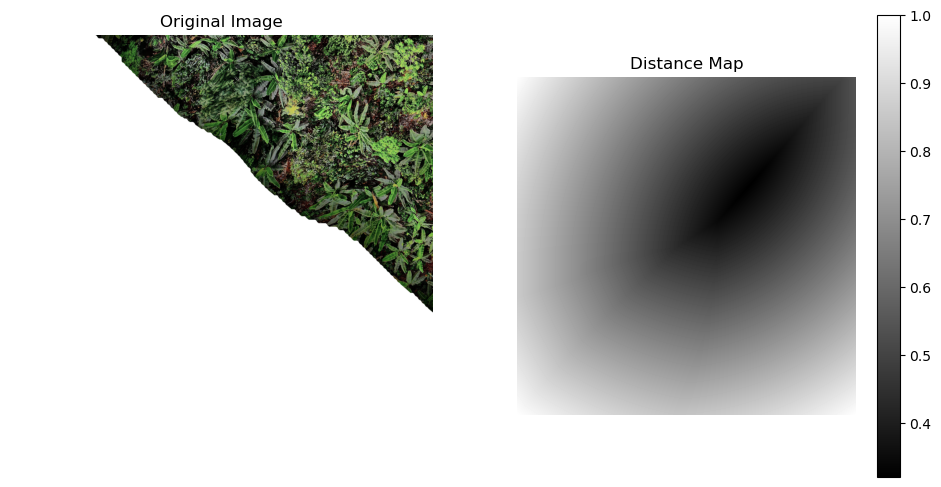

In [16]:
distance_map_dir = 'data/precomputed_distance_maps'
image_dir = 'data/tiles/processed'
img_path = 'Nestor Macias RGB_3_0_9024_4000_13024.png'  
visualize_distance_map(distance_map_dir, img_path, image_dir)

## Custom Dataset 

In [17]:
class TreeCrownDataset(Dataset):
    def __init__(self, dataframe, root_dir, distance_map_dir, split, transform=None, val_size=0.15, test_size=0.15, random_state=42):
        self.root_dir = root_dir
        self.distance_map_dir = distance_map_dir
        self.transform = transform
        
        # Split the dataframe into train, validation, and test sets
        train_val_df, test_df = train_test_split(dataframe, test_size=test_size, random_state=random_state)
        train_df, val_df = train_test_split(train_val_df, test_size=val_size / (1 - test_size), random_state=random_state)

        if split == 'train':
            self.dataframe = train_df
        elif split == 'val':
            self.dataframe = val_df
        elif split == 'test':
            self.dataframe = test_df
        else:
            raise ValueError("split must be one of 'train', 'val', or 'test'")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.root_dir, row['img_path'])
        image = Image.open(img_path).convert('RGB')
        
        # Get metadata
        species = row['name']
        species_label = torch.tensor(0 if species == 'Musacea' else 1 if species == 'Guaba' else 2 if species == 'Cacao' else 3 if species == 'Mango' else 4, dtype=torch.long)
        carbon = torch.tensor(row['carbon'], dtype=torch.float32)
        bbox = torch.tensor([row['xmin'], row['ymin'], row['xmax'], row['ymax']], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        # Load precomputed distance map
        distance_map_filename = f"{row['img_path'].replace('.png', '.pkl.bz2')}"
        distance_map_path = os.path.join(self.distance_map_dir, distance_map_filename)
        
        if os.path.exists(distance_map_path):
            with bz2.BZ2File(distance_map_path, 'rb') as f:
                distance_map = pickle.load(f)
            distance_map = torch.from_numpy(distance_map).unsqueeze(0)  # Add channel dimension
        else:
            # Handle missing distance map files
            print(f"Warning: Distance map for {row['img_path']} not found.")
            distance_map = torch.zeros((1, image.size[1], image.size[0]), dtype=torch.float32)  # Create an empty distance map
        
        return image, species_label, distance_map, bbox, carbon

In [18]:
root_dir = 'data/tiles/processed'

## Loading and Visualizing Data

In [19]:
df_subset = df.sample(frac=0.1, random_state=42)

#using a smaller dataset for memory constraints 
train_dataset = TreeCrownDataset(dataframe=df_subset, root_dir=root_dir, distance_map_dir=distance_map_dir, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
test_dataset = TreeCrownDataset(dataframe=df_subset, root_dir=root_dir, distance_map_dir=distance_map_dir, split='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=0)
val_dataset = TreeCrownDataset(dataframe=df_subset, root_dir=root_dir, distance_map_dir=distance_map_dir, split='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

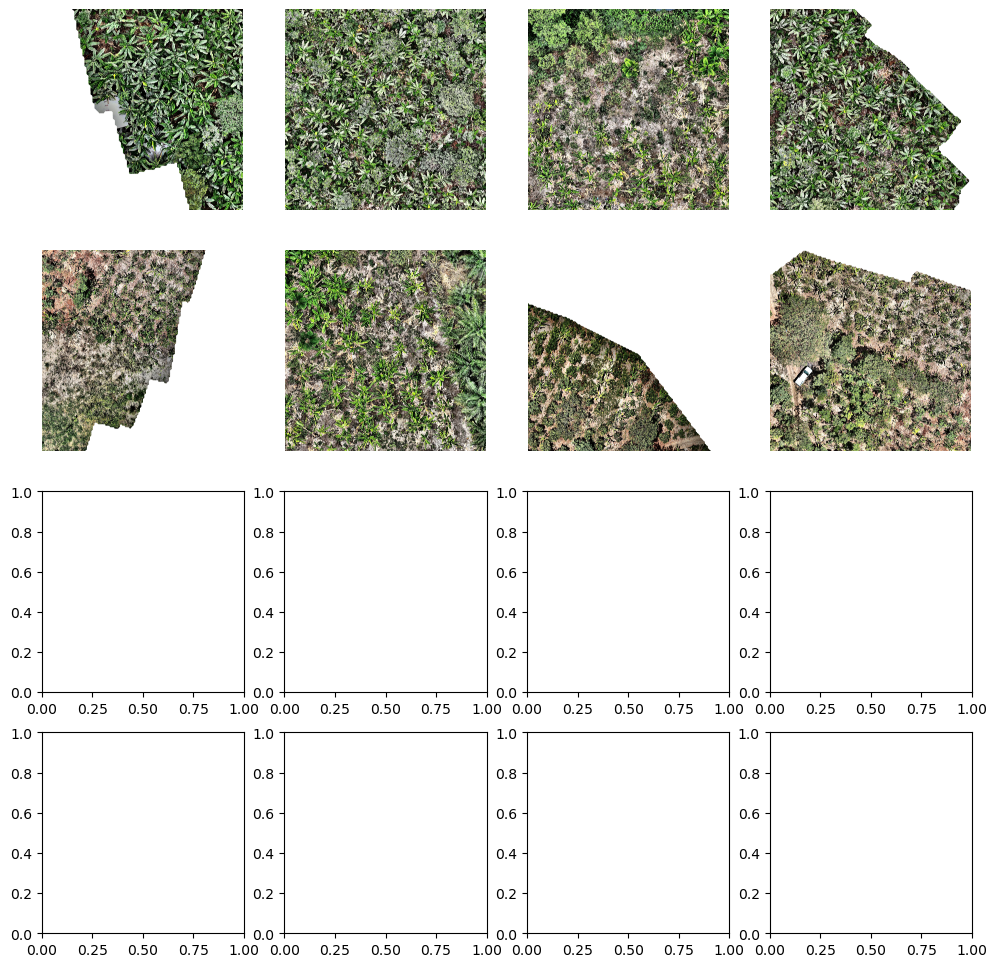

In [20]:
#visualizing some of the augmented and processed images from the training dataset
def show_images(images, nrow=2, ncol=4):
    fig, axes = plt.subplots(nrow, ncol, figsize=(12, 12))
    for i, img in enumerate(images):
        if i >= nrow * ncol:
            break
        ax = axes[i // ncol, i % ncol]
        img = img.permute(1, 2, 0)  # Rearrange dimensions for matplotlib (C, H, W) -> (H, W, C)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Get a batch of images from the dataloader
data_iter = iter(train_loader)
images, species, distance, bboxes, carbon = next(data_iter)

# Show the images
show_images(images, nrow=4, ncol=4)

## Setting Device

In [21]:
#setting the device to use a GPU
def set_device(device="cpu", idx=0):
    """
    Set the device for PyTorch operations.

    Parameters:
    - device (str, optional): Device to use ("cpu" or "cuda"). Default: "cpu".
    - idx (int, optional): Index of the GPU device if using CUDA. Default: 0.

    Returns:
    - str: The selected device.
    """
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

No GPU available! Running on CPU


## Establishing the Model Architecture

In [22]:
#Establishing the encoder 

class ResNet18Encoder(nn.Module):
    def __init__(self):
        super(ResNet18Encoder, self).__init__()
        self.resnet = models.resnet18(pretrained=True)  
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])  # Remove last layers

    def forward(self, x):
        return self.resnet(x)

In [23]:
#Semantic segmentation decoder using DeepLabV3

class SemanticSegmentationDecoder(nn.Module):
    def __init__(self, num_classes):
        super(SemanticSegmentationDecoder, self).__init__()
        self.deeplab_head = DeepLabHead(512, num_classes)  

    def forward(self, x):
        return self.deeplab_head(x)


In [24]:
#Distance map regression decoder 

class DistanceMapDecoder(nn.Module):
    def __init__(self):
        super(DistanceMapDecoder, self).__init__()
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(256, 1, kernel_size=1)  # Single channel output for distance map

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.Sigmoid()(self.conv2(x))
        return x


In [25]:
#Implmenting partially weighted categorical focal loss 

class PartiallyWeightedCategoricalFocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, beta=0.75):
        super(PartiallyWeightedCategoricalFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta

    def forward(self, input, target):
        # Compute cross entropy
        ce_loss = nn.CrossEntropyLoss(reduction='none')(input, target)

        # Compute focal loss
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        # Compute the weights
        weights = torch.where(target == 0, self.alpha, self.beta)

        # Apply the weights
        loss = weights * focal_loss

        return loss.mean()

In [26]:
#combining into SEDD model
class SEDDModel(nn.Module):
    def __init__(self, num_classes):
        super(SEDDModel, self).__init__()
        self.encoder = ResNet18Encoder()
        self.semantic_decoder = SemanticSegmentationDecoder(num_classes)
        self.distance_decoder = DistanceMapDecoder()

    def forward(self, x):
        encoded = self.encoder(x)
        semantic_output = self.semantic_decoder(encoded)
        distance_output = self.distance_decoder(encoded)
        return semantic_output, distance_output

In [27]:
#training and validation functions 

def final_loss(semantic_loss, distance_loss):
    return semantic_loss + distance_loss

def fit(model, dataloader, optimizer, semantic_loss_fn, distance_loss_fn):
    model.train()
    running_loss = 0.0

    for images, semantic_targets, distance_targets, _, _ in dataloader:
        images = images.to(device)
        semantic_targets = semantic_targets.to(device)
        distance_targets = distance_targets.to(device)

        optimizer.zero_grad()
        semantic_outputs, distance_outputs = model(images)

        semantic_loss = semantic_loss_fn(semantic_outputs, semantic_targets)
        distance_loss = distance_loss_fn(distance_outputs, distance_targets)
        loss = final_loss(semantic_loss, distance_loss)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(dataloader.dataset)
    return train_loss

def validate(model, dataloader, semantic_loss_fn, distance_loss_fn):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, semantic_targets, distance_targets, _, _ in dataloader:
            images = images.to(device)
            semantic_targets = semantic_targets.to(device)
            distance_targets = distance_targets.to(device)

            semantic_outputs, distance_outputs = model(images)
            semantic_loss = semantic_loss_fn(semantic_outputs, semantic_targets)
            distance_loss = distance_loss_fn(distance_outputs, distance_targets)
            loss = final_loss(semantic_loss, distance_loss)

            running_loss += loss.item()

    val_loss = running_loss / len(dataloader.dataset)
    return val_loss

## Training the Model 

In [28]:
num_epochs = 2
model = SEDDModel(num_classes=5).to(device)
semantic_loss_fn = PartiallyWeightedCategoricalFocalLoss(alpha=0.25).to(device)
distance_loss_fn = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/IRP_2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


: 

In [29]:
import torch
import psutil
import time
from livelossplot import PlotLosses

def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"RSS: {mem_info.rss / 1024 ** 2:.2f} MB, VMS: {mem_info.vms / 1024 ** 2:.2f} MB")

# Setting the device to use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move it to the device
model = SEDDModel(num_classes=5).to(device)

# Define loss functions
semantic_loss_fn = PartiallyWeightedCategoricalFocalLoss(alpha=0.25)
distance_loss_fn = torch.nn.MSELoss()  # Mean Squared Error for distance map regression

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def fit(model, dataloader, optimizer, semantic_loss_fn, distance_loss_fn):
    model.train()
    print("Entered fit function")
    start_time = time.time()
    running_loss = 0.0

    for i, (images, species, distance, bboxes, carbon) in enumerate(dataloader):
        load_time = time.time()
        print(f"Batch {i} - Data Loading Time: {load_time - start_time:.2f} sec")
        
        images = images.to(device)
        species = species.to(device)
        distance = distance.to(device)
        
        data_to_device_time = time.time()
        print(f"Batch {i} - Data to Device Time: {data_to_device_time - load_time:.2f} sec")

        optimizer.zero_grad()

        compute_start_time = time.time()
        print(f"Batch {i} - Optimizer Zero Grad Time: {compute_start_time - data_to_device_time:.2f} sec")

        semantic_outputs, distance_outputs = model(images)
        semantic_loss = semantic_loss_fn(semantic_outputs, species)
        distance_loss = distance_loss_fn(distance_outputs, distance)
        loss = semantic_loss + distance_loss

        loss_calculation_time = time.time()
        print(f"Batch {i} - Loss Calculation Time: {loss_calculation_time - compute_start_time:.2f} sec")

        loss.backward()
        
        loss_backward_time = time.time()
        print(f"Batch {i} - Loss Backward Time: {loss_backward_time - loss_calculation_time:.2f} sec")

        optimizer.step()

        optimizer_step_time = time.time()
        print(f"Batch {i} - Optimizer Step Time: {optimizer_step_time - loss_backward_time:.2f} sec")

        running_loss += loss.item()

        if i % 10 == 0:
            print(f"Batch {i}/{len(dataloader)} - Total Batch Time: {time.time() - load_time:.2f} sec")

    train_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch Training Time: {time.time() - start_time:.2f} seconds")
    return train_loss

def validate(model, dataloader, semantic_loss_fn, distance_loss_fn):
    model.eval()
    start_time = time.time()
    running_loss = 0.0
    with torch.no_grad():
        for i, (images, species, distance, bboxes, carbon) in enumerate(dataloader):
            load_time = time.time()
            print(f"Validation Batch {i} - Data Loading Time: {load_time - start_time:.2f} sec")
            
            images = images.to(device)
            species = species.to(device)
            distance = distance.to(device)
            
            data_to_device_time = time.time()
            print(f"Validation Batch {i} - Data to Device Time: {data_to_device_time - load_time:.2f} sec")

            semantic_outputs, distance_outputs = model(images)
            semantic_loss = semantic_loss_fn(semantic_outputs, species)
            distance_loss = distance_loss_fn(distance_outputs, distance)
            loss = semantic_loss + distance_loss

            loss_calculation_time = time.time()
            print(f"Validation Batch {i} - Loss Calculation Time: {loss_calculation_time - data_to_device_time:.2f} sec")

            running_loss += loss.item()

    val_loss = running_loss / len(dataloader.dataset)
    print(f"Validation Epoch Time: {time.time() - start_time:.2f} seconds")
    return val_loss

# Number of epochs
num_epochs = 2

# Initialize liveplot
liveplot = PlotLosses()

# Training loop
for epoch in range(num_epochs):
    logs = {}
    epoch_start_time = time.time()
    print(f'Epoch {epoch+1}/{num_epochs}')
    print_memory_usage()

    # Training step
    train_loss = fit(model, train_loader, optimizer, semantic_loss_fn, distance_loss_fn)
    print_memory_usage()
    print("Finished training epoch")

    # Validation step
    val_loss = validate(model, val_loader, semantic_loss_fn, distance_loss_fn)
    print_memory_usage()
    print("Finished validation epoch")

    logs['log loss'] = train_loss
    logs['val_log loss'] = val_loss

    liveplot.update(logs)
    liveplot.draw()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    print(f"Epoch {epoch+1} Total Time: {time.time() - epoch_start_time:.2f} seconds")

    # Save the model
    torch.save(model.state_dict(), f"SEDDModel_epoch_{epoch+1}.pth")


Epoch 1/2
RSS: 5114.73 MB, VMS: 408155.94 MB
got past model training
got past data loader


In [ ]:
liveplot = PlotLosses()

for epoch in range(num_epochs):
    logs = {}
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    train_loss = fit(model, train_loader, optimizer, semantic_loss_fn, distance_loss_fn)
    print("Got here")
    val_loss = validate(model, val_loader, semantic_loss_fn, distance_loss_fn)
    print("got here")
    
    logs['log loss'] = train_loss
    logs['val_log loss'] = val_loss

    liveplot.update(logs)
    liveplot.draw()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Save the model
torch.save(model.state_dict(), "SEDDModel.pth")

Epoch 1/2


: 